# Delays is Zürich's tram network

## Preliminaries

Import standard Python libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns

I have custom-made a number of functions for analysis of tram data, and stored them in the module named func_definitions. Import this module: 

In [2]:
import func_definitions as fd

Now load the data for analysis. The file "haltestelle.csv" contains information about all the stops in Zürich's tram network. The file "fahrzeiten..." is the actual dataset with detailed information about the tram itineraries during a specific week. The city of Zürich releases one such dataset per week. Here, the dataset for the week of Jan 5, 2020 is assigned to "trams". Any other such dataset (or several weekly datasets stacked on top of each other) could alternatively be assigned. Then, the functions in the func_definitions module could be used in the same way to check whether data from different weeks gives the same or different results as the ones found in this notebook. 

In [3]:
trams=pd.read_csv("fahrzeiten_soll_ist_20200105_20200111.csv")
stops=pd.read_csv("haltestelle.csv")

Briefly inspect the information contained in the dataset by displaying the column names:

In [4]:
print(trams.columns)

Index(['linie', 'richtung', 'betriebsdatum', 'fahrzeug', 'kurs', 'seq_von',
       'halt_diva_von', 'halt_punkt_diva_von', 'halt_kurz_von1', 'datum_von',
       'soll_an_von', 'ist_an_von', 'soll_ab_von', 'ist_ab_von', 'seq_nach',
       'halt_diva_nach', 'halt_punkt_diva_nach', 'halt_kurz_nach1',
       'datum_nach', 'soll_an_nach', 'ist_an_nach1', 'soll_ab_nach',
       'ist_ab_nach', 'fahrt_id', 'fahrweg_id', 'fw_no', 'fw_typ', 'fw_kurz',
       'fw_lang', 'umlauf_von', 'halt_id_von', 'halt_id_nach',
       'halt_punkt_id_von', 'halt_punkt_id_nach'],
      dtype='object')


Each row of the dataset corresponds to a journey from one stop to the next. Arrival at and departure from each of the two stops are recorded, as well as the line and route to which the journey belonged.  There is additional information about the vehicle itself, which I ignore in this analysis.  

Now make a selection of the relevant columns and rows from the dataset. For the analysis, I want to focus on trams only, so I eliminate information about line numbers greater than 15. (Note that the former tram line 17 has recently been discontinued.) Any larger numbers refer to bus lines or some "special" lines (vintage trains, Forchbahn etc.). I also exclude information about journeys of trams which go from a stop to that same stop. (Probably, these are instances where the same stop has different platforms for dropping off passengers and taking on board new passengers, which would typically occur at an endpoint of a line where the tram turns around and goes back.)

In [5]:
trams_cols=["linie","fw_lang","richtung","betriebsdatum","halt_kurz_von1","soll_an_von","ist_an_von","soll_ab_von",
            "ist_ab_von","halt_kurz_nach1","soll_an_nach","ist_an_nach1","halt_id_von","halt_id_nach"]
trams=trams[trams_cols]
trams=trams[trams["linie"]<=15]
trams=trams[trams["halt_kurz_von1"]!=trams["halt_kurz_nach1"]]

The "stops" dataframe contains information about each stop in the public transport network. I want to use it to convert different identifiers of a stop to each other. In particular, each stop can be identified by an id, a short name, and a long name. Select from the dataframe the columns with these identifiers.

In [6]:
stop_cols=["halt_id","halt_lang","halt_kurz"]
stops=stops[stop_cols]

Now get an overview of all tram lines in the dataset. Indeed, we have information on all fourteen lines. (Note that there is no Line 1.)

In [7]:
all_lines=np.sort(trams["linie"].unique())
print(all_lines)

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


Zürich's tram network associates to each line a distinct color, as specified in the following dictionary. These colors will be used later in the visualizations. 

In [8]:
line_colors={2:"#E20A16", 3:"#00892F",4:"#11296F",
             5:"#734522", 6:"#CA7D3C", 7:"#000000",
             8:"#8AB51F", 9:"#11296F", 10:"#E12472",
             11:"#00892F", 12:"#5EB3DB",
             13:"#FFC100", 14:"#008DC5",
             15:"#E20A16"}

Now define some extra columns in the trams dataframe which distill the information needed later: For each stop, compute the delay when the tram arrives at the stop and when it leaves. This allows us to compute the holdup at each stop and on each trajectory. Throughout, I will use "delay" to refer to the total amount by which a tram is late at a given location (negative delay means it is early), and I will use "holdup" to refer to the amount of time that a tram loses (or gains, if negative) at a specific location.

In [9]:
trams["delay_at_arrival"]=trams["ist_an_von"]-trams["soll_an_von"]
trams["delay_at_departure"]=trams["ist_ab_von"]-trams["soll_ab_von"]
trams["delay_after_trajectory"]=trams["ist_an_nach1"]-trams["soll_an_nach"]
trams["holdup_stop"]=trams["delay_at_departure"]-trams["delay_at_arrival"]
trams["holdup_trajectory"]=trams["delay_after_trajectory"]-trams["delay_at_departure"]
trams["total_holdup"]=trams["holdup_stop"]+trams["holdup_trajectory"]

For each line, trams can operate on various routes. Most often, a tram's route will lead from one endpoint of a line to its other endpoint. There are also other routes, however: One example is the route from the endpoint of a line to a depot. 
The custom-made function fd.main_routes_of_line() identifies the two routes that are most frequent on any given line, according to the dataset. Indeed, these will be the routes connecting the two endpoints of the line. For the analysis, let us focus on these main routes of each line, and remove from the dataset information pertaining to other routes.

In [10]:
main_routes_all_lines=[]
for line in all_lines:
    main_routes_all_lines.append(fd.main_routes_of_line(line,trams)[0])
    main_routes_all_lines.append(fd.main_routes_of_line(line,trams)[1])


trams=trams[trams["fw_lang"].isin(main_routes_all_lines)]

For illustration, let us look up the main routes of line 15:

In [11]:
print(fd.main_routes_of_line(15,trams))

['BUCH - BSTA' 'BSTA - BUCH']


The tram network uses shortcuts (four to six characters) to identify each stop. In the case at hand, the meaning of the shortcut is easy to guess: Knowledge of the city tells us that the endpoints of line 15 are at Bucheggplatz and Bahnhof Stadelhofen. However, we want an efficient way to translate shortcuts into full names of stops. To this end, we need the information contained in the dataframe called "stops".

I use a left join to add this information to the "trams" dataframe. It is convenient to eliminate the prefix "Zürich" from the names of the stops. That way, the data becomes more legible. Stops that are outside of Zürich's municipal area are then recognisable by the prefixed name of the municipality.

In [12]:
trams=trams.merge(stops, left_on="halt_id_von",right_on="halt_id",how="left")
trams["halt_lang"]=trams["halt_lang"].str.replace("Zürich, ","").str.replace("Zürich,","")

For illustration, let us get the name of a stop in Zürich and one located outside of city limits in Dübendorf:

In [13]:
print(fd.convert_short_to_long("HEDW",trams))

Hedwigsteig


In [14]:
print(fd.convert_short_to_long("RINW07",trams))

Dübendorf, Ringwiesen


Check for any missing data: In this case, it is easy: No values are missing!

In [15]:
print(trams.isnull().sum().sum())

0


One problem with the dataset remains, however: A stop at Zürich airport is referred to by a different shortcut when routes are specified ("FRAF") as opposed to when the stops themselves are designated ("FRAF07").

In [16]:
print(fd.main_routes_of_line(12,trams))

['BSTE - FRAF' 'FRAF - BSTE']


In [17]:
only_line_12=trams[trams["linie"]==12]
print(only_line_12["halt_kurz_von1"].unique())

['BABH07' 'ZFER' 'BELA07' 'UNTR07' 'FRAF07' 'RBAU07' 'WNEU07' 'BWAL07'
 'WGLA07' 'DGIE07' 'RINW07' 'GLIN07' 'ZAUZ' 'BGLA07' 'HRTI07' 'GGLA07'
 'FLUG07' 'BSTE']


To circumvent this issue, change the designation of the route so that it conforms to the shortcut for the stop.

In [18]:
trams["fw_lang"]=trams["fw_lang"].str.replace("FRAF","FRAF07")

Now the "trams" dataframe is ready for use!

# Comparison of holdups and delays on different tram lines

One question that the dataset can help answer is: Which lines in the tram network have most delays? Which trams are most often on time? The data is rich enough to dig deeper as well: For instance, we could ask whether delays tend to occur because trams spend too much time at stops, or because they loose time as they travel from one stop to the next. We could also ask how often trams have major delays. The functions in the func_definitions module help address these questions from three different angles: First, by looking at average holdups, delays, and deviations. Second, by checking the frequency of major delays. Third, by considering entire distributions of delay data. 

### Using plain averages

Start by visually comparing the amount of delay on different lines of the tram network.

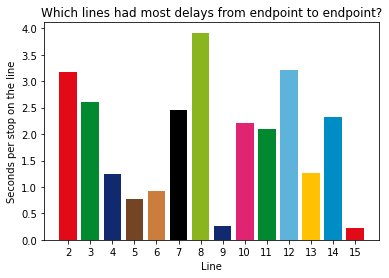

In [19]:
fd.figure_lines(all_lines,line_colors,trams)

Note that the vertical axis in the figure measures delay in seconds divided by the number of stops on the line. It seems natural to expect more delays to accumulate on a long line than on a short line: An incident which causes a small delay propagates over a longer journey, and the probability of having several incidents on the line increases. Measuring delays "per stop" corrects for this effect. However, there are also cases where we might be interested in the total amount of delay that accumulates over a line: For instance, this could be the case when the timetable itself is already designed to allow for more slack on a longer line. It could also be interesting if we want to know whether drivers get sufficient breaks at final stops. Thus, I have created the possibility to turn off the correction for the number of stops, setting the parameter "per_stop" to "False" as shown below: 

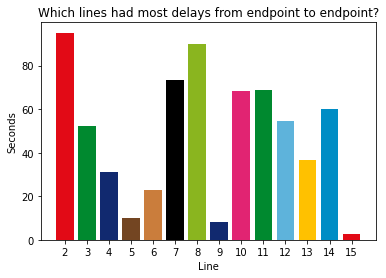

In [20]:
fd.figure_lines(all_lines,line_colors,trams,per_stop=False)

Note that the vertical axis is now simply in seconds. Some main observations are true regardless whether or not we correct for the length of the line: Either way, we see that lines 2 and 8 tend to have the biggest delays, while line 15 is very punctual.

So far, we focused on the amount of delay that accumulates as a tram travels to its destination. Alternatively, however, it could be interesting to ask how much a tram deviates from its timetable rather than by how much it is delayed. Suppose, for instance, that a tram loses 20 seconds on the way from stop A to stop B, but then it is 20 seconds faster than scheduled on the way from stop B to stop C. There is no delay on the route from A to C, but there are deviations from the timetable that sum to 40 seconds. I have included the optional argument "what" that allows us to visualize the total amount of deviation from the timetable rather than the total amount of delay. Again, we can choose if we want to see the result just in seconds or in seconds per stop on the line.

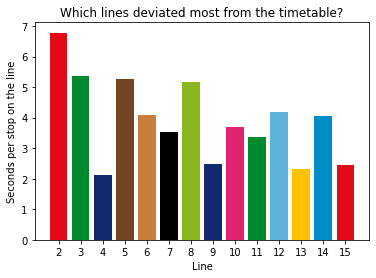

In [21]:
fd.figure_lines(all_lines,line_colors,trams,what="deviation")

Another option that I built into the fd.figure_line() function is to consider only the amount of delay that results from holdups on trajectories (that is, a tram needs more time to travel between stops) or only the delay that results from holdups at stops (that is, the tram spends more or less time at the stops than it should). Let's explore the latter possibility:

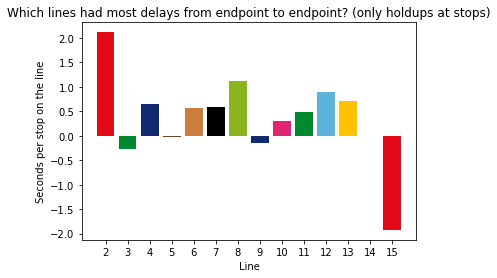

In [22]:
fd.figure_lines(all_lines, line_colors,trams,which_holdup="at_stop")

We already saw that Lines 2 and 8 are most delayed on average. Now we see that the trams on these lines are also held up the most at stops. Line 15, which does not have a lot of delays, even gains time at stops: On average, it stays about two seconds less than scheduled at each of its stops. Since it does not arrive early overall, however, it must be the case that it loses time between the stops.

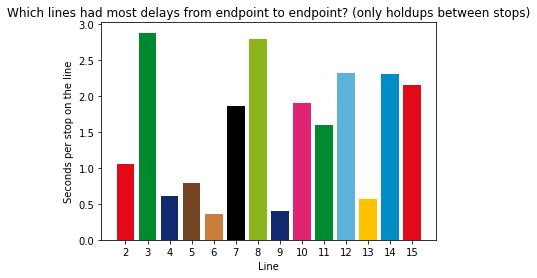

In [23]:
fd.figure_lines(all_lines,line_colors,trams,which_holdup="on_trajectory")

Indeed, when considering only holdups on trajectories, than line 15 has quite a lot of such holdup. For some reason,
the timetable of line 15 allows too little time between stops, but too much time at stops. Since these effects outweigh
each other to some extent, tram 15 is rather punctual on the whole, however.

### Using frequency of major delays

So far, we have been looking only at averages: How much delay does a tram on average accumulate as it travels on a line? How long is the tram held up on average at specific stops or on specific trajectories? Alternatively, one could also define a threshold above which a holdup or an overall delay is considered problematic. For instance, management may think that a delay of 30s accumulated over the entire line is within an acceptable "error margin," while a greater delay is an issue. If this is how we look at it, then we want to know how likely a major delay is rather than how much delay there is on average. Let us take this approach next. Indeed, we can use one function in my module to do this, like so: 

In [24]:
print(fd.freq_major_delays_route("REHA - ZAUZ",trams,30,per_stop=False))

(929, 577, 62.11)


Now we know that, in the dataframe "trams", there are 929 observations regarding the route "REHA - ZAUZ", and of those 683 (or 73.52%) arrived at the endpoint more than 10 seconds late. We can also compare lines to each other. For instance, we could ask: "For each line, what is the percentage of trams that arrive at the line's endpoint at least 90 seconds late?"

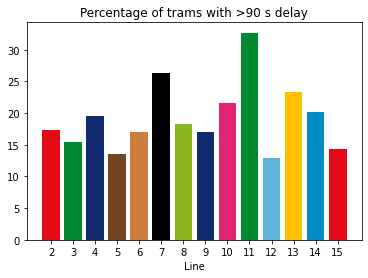

None


In [25]:
print(fd.plot_major_delays_lines(all_lines,line_colors,trams,90,per_stop=False))

### Using entire distributions

We have already considered the average amounts of delay and the frequency of major delays. In order to get more detailed information, we may also be interested in the entire distribution of delays. The following function generates a dataframe which shows, for each tram line, all the delays that have been observed on journeys between endpoints.

In [26]:
table=fd.table_delays_lines(all_lines,trams)

In [27]:
print(table.shape)
print(table.isnull().sum())

(1854, 14)
2      65
3      26
4      90
5     477
6      88
7      78
8      26
9     442
10    844
11      0
12    837
13     11
14      5
15    836
dtype: int64


In this case, there are 1854 rows, implying that there are at most 1854 observations for any particular line. Since no values are missing for line 11, this is actually the line with 1854 observations. For the other lines, we have fewer observations. For instance, on line 15, we have 836 missing values or 1854-836 = 1018 observations. 

For any given line (or array of lines) we can now depict the entire distribution of delays (this is done as a density plot), for example let's look at line 8:

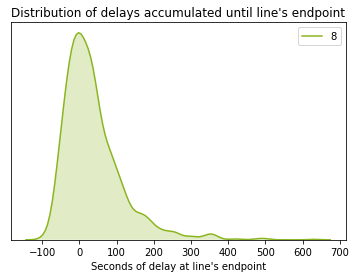

In [28]:
fd.dist_lines([8],trams,line_colors)

## Digging deeper

Now let us take a closer look at some of the observations that we could make from the visualizations above.

### A closer look at line 5

What we have seen so far is that line 5 does not have a lot of delays on average, but it shows quite some deviations from its timetable. In order to check in more detail how this comes about, we can check the amount of holdup on the different parts of line 5, using the following function:

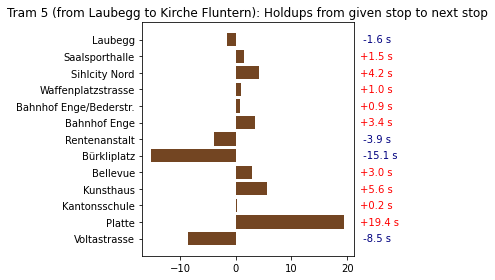

In [29]:
fd.plot_overview_for_line(5,line_colors,trams)

The barplot shows us the amount of holdup between a tram's arrival at the given stop and its arrival at the following stop. (Note that there is a bar for the first stop but not for the final stop.) We see that a lot of holdup occurs at Platte, while the tram gains time at Bürkliplatz. This contributes to the deviations from the timetable, but not to overall delay. With regard to the holdup at Platte, we can speculate why this might happen. There are two important facts: First, the stop at Platte is the one where the itineraries of lines 5 and 6 merge, and these trams frequently need to wait for one another.
Second, there is major construction site on the way from Platte to Voltastrasse. To investigate this further, let's restrict attention to holdups at stops by using the optional argument which_holdup:

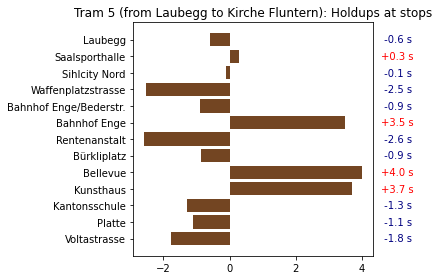

In [30]:
fd.plot_overview_for_line(5,line_colors,trams,which_holdup="at_stop")

Now we see that, contrary to our first speculation, there is no problem with the stop at Platte. Hence, the holdup must arise on the trajectory from Platte to Voltastrasse, where the construction site is. We can corroborate this conclusion in several ways: First, we can use the reverse parameter to look at the same line in the opposite direction:

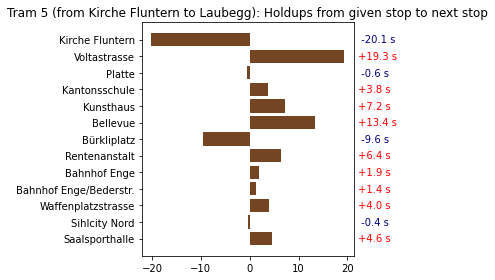

In [31]:
fd.plot_overview_for_line(5,line_colors,trams,reverse=True)

Indeed, we see holdup between Voltastrasse and Platte, and just to make sure that this is not caused by a problem with the stop at Voltastrasse, we can use again the which_holdup parameter: 

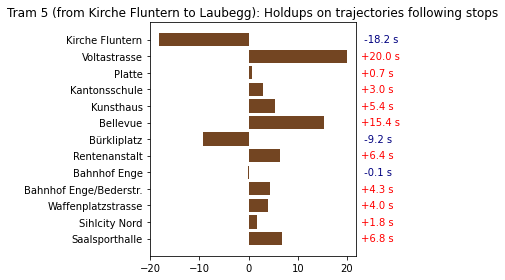

In [32]:
fd.plot_overview_for_line(5,line_colors,trams,reverse=True,which_holdup="on_trajectory")

Indeed, line 5 also loses an average of 20 seconds on the trajectory between Voltastrasse and Platte when it travels in the downhill direction. Finally, we can also check for the analoguous holdup on line 6, which also stops at both Platte and Voltastrasse, like so:

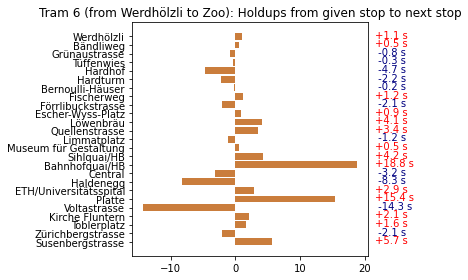

In [33]:
fd.plot_overview_for_line(6,line_colors,trams)

Indeed, the data for line 6 also shows holdup at Platte. What the above plots also suggest, however, is that trams manage to catch up with the timetable between the sops at Voltastrasse and Kirche Fluntern, so that there is only little "net delay" on the way from Kirche Fluntern to Platte, or the reverse. 

### Finding origin of delays on line 7

We have seen that line 7 is among the lines most likely to have a delay of more than 90 seconds upon arrival at its endpoint.
(This is taking into account observations for both directions.) Once we know that a particular line is more prone to delays than other lines, we may wonder where exactly on the line these problems originate. To this end, we can check for each stop on the line how likely it is that a holdup of more than a given number of seconds occurs there. For line 7, it looks as follows:

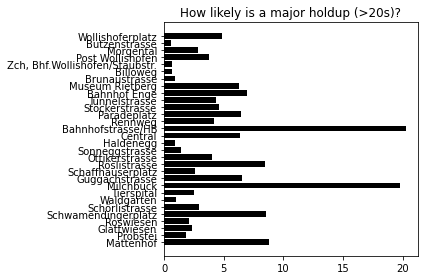

In [34]:
fd.fig_major_holdups_line(7,20,line_colors,trams)

On line 7, we can identify two locations at which holdup exceeds 20 seconds about 20 percent of the time: Bahnhofstrasse and Milchbuck. Now let's check if the same is also true in the opposite direction of travel:

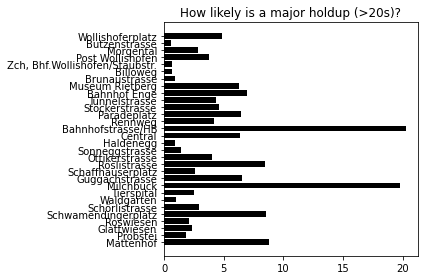

In [35]:
fd.fig_major_holdups_line(7,20,line_colors,trams)

Now we can see more clearly where delays on line 7 tend to come from: Apparently, Bahnhofstrasse/HB and Milchbuck are the most critical points on the line. 

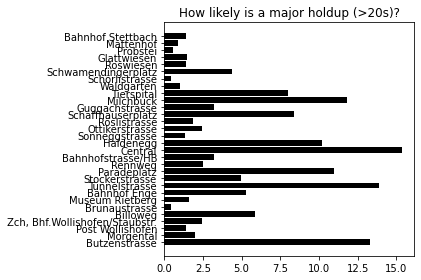

In [36]:
fd.fig_major_holdups_line(7,20,line_colors,trams,reverse=True)

Also in the opposite direction, a lot of holdup tends to occur between Central and Bahnhofstrasse. Other critical points on the line seem to differ, however, depending on the direction of travel. For instance, major holdup tends to occur between Tunnelstrasse and Bahnhof Enge (according to this plot), but not between Bahnhof Enge and Tunnelstrasse (according to the previous plot). It is easy to explain the high probability of major holdups on the section from Bahnhofstrasse to Central: This part of the network is very busy and used by several tram lines. It is also true that several tram lines meet at Bahnhof Enge, however, so it is not immediately clear why the propensity to holdup differs so much per direction. We can speculate that it must have something to do with the way that priority is given to different trams, different directions, and other traffic at the junction close to Bahnhof Enge.  

### Comparison of two lines: 11 and 15

Another possibility is to compare two lines in detail. One interesting case is the comparison of lines 11 and 15. While line 11 is one of the longest lines in the network, line 15 is the shortest. The endpoints of line 15 (Bahnhof Stadelhofen and Bucheggplatz) are also stops on line 11, but the two lines move on different paths between these two stops. Let us first compare the amount of delay which a tram on each line accumulates on average:

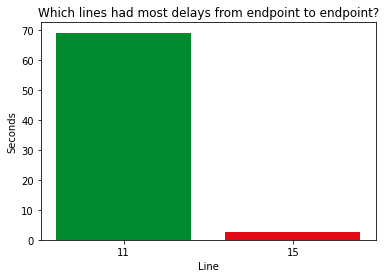

In [37]:
fd.figure_lines([11,15],line_colors,trams,per_stop=False)

By this standard, line 15 is much more punctual than line 11. As already mentioned, line 11 is much longer, so one might suspect that the difference vanishes if one relates the accumulated delay to the number of stops on the line. This turns out to have only a small effect, however: 

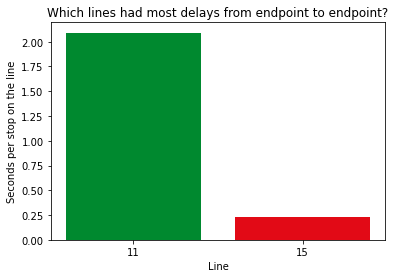

In [38]:
fd.figure_lines([11,15],line_colors,trams)

Either way, line 15 trams remain much more punctual than those on line 11.
Instead of looking to the lines' length for an explanation, we can use our knowledge of the city again:
The itinerary of line 15 avoids some notoriously busy parts of Zürich's inner city area, in particular Bahnhofstrasse, the main station, and Paradeplatz.  

If, instead of looking at average delays, we consider the probability of a major delay, say more than ninety seconds, the difference in punctuality between both lines becomes less striking. 

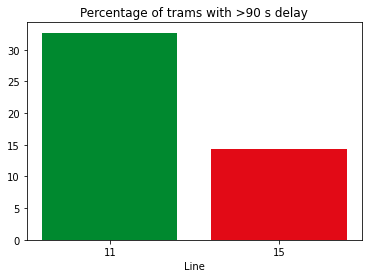

In [39]:
fd.plot_major_delays_lines([11,15],line_colors,trams,90,per_stop=False)

In principle, we could draw similar plots to see how likely a delay of more than 120 (150, 180, ...) seconds is. In order to display this kind of information more precisely, however, I have included a function which allows us to compare the distribution of delays directly by plotting their densities:

C:\Users\Volker\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Volker\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


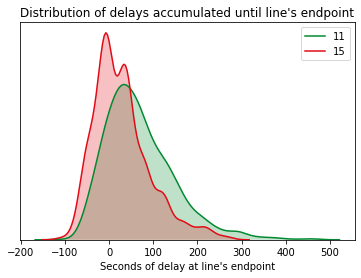

In [40]:
fd.dist_lines([11,15],trams,line_colors)

Indeed, we can clearly see that not only is line 15 less delayed than line 11, there is also less variance in its delays. 

Finally, we may ask ourselves how likely it is that a tram experiences a major holdup at any one particular stop. For instance, we may wonder, "What percentage of line 11 trams loses more than ten seconds relative to its timetable from its arrival at Bahnhof Stadelhofen and its arrival at the next stop, Bellevue?" This information can be displayed using the following function. (The answer is: approximately 26%)

In [41]:
print(fd.freq_major_holdups_all_stops(11,10,trams))

                     Percentage
Rehalp                 1.614639
Friedhof Enzenbühl     3.767492
Balgrist               4.843918
Burgwies               4.628633
Wetlistrasse           3.982777
Hedwigsteig            6.781485
Hegibachplatz          8.396125
Signaustrasse          6.458558
Kreuzplatz            12.055974
Bahnhof Stadelhofen   25.969828
Bellevue              20.280475
Bürkliplatz           45.415318
Kantonalbank           3.775620
Paradeplatz           25.646552
Rennweg               20.280475
Bahnhofstrasse/HB     36.785329
Bahnhofquai/HB        41.379310
Stampfenbachplatz      7.435345
Beckenhof              5.387931
Kronenstrasse         17.349138
Schaffhauserplatz     11.948332
Laubiweg               3.659849
Bucheggplatz          29.386437
Radiostudio           24.757804
Bad Allenmoos         16.684607
Regensbergbrücke      11.087191
Bahnhof Oerlikon      10.979548
Sternen Oerlikon      32.077503
Messe/Hallenstadion   12.271259
Leutschenbach          5.597417
Oerliker

We can also verify whether this percentage is similar for the line 15 tram between the same two stops. (Note that this function also accepts the reverse parameter to control the direction of travel to consider.)

In [44]:
print(fd.freq_major_holdups_all_stops(15,10,trams,reverse=True))

                     Percentage
Bahnhof Stadelhofen   29.076621
Bellevue              27.111984
Helmhaus               3.339882
Rathaus                5.108055
Rudolf-Brun-Brücke    15.324165
Central               35.363458
Haldenegg              4.518664
Sonneggstrasse         6.090373
Ottikerstrasse        19.842829
Röslistrasse          21.021611
Schaffhauserplatz      9.233792
Laubiweg               4.518664


Not surprisingly, trams of both lines have a similar probability to be held up by more than ten seconds on the stretch from Bahnhof Stadelhofen to Bellevue. Their risk of substantial holdup is also similar on the other trajectory that both lines share, namely from Laubiweg to Bucheggplatz.